In [126]:
import sys
sys.path.append('D:/UNESP/EngMec-UNESP/')
import frankenstein as fk

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import linregress
from uncertainties import ufloat
from uncertainties.umath import *  # sin(), etc.
import ZebraLib as zb
import uncertainties.unumpy as un

df = pd.read_excel('D:/UNESP/EngMec-UNESP/Lab. Mec Flu II/Lab 3 - Perda de carga/dados3.xlsx', 
                    sheet_name='df_data')

df3 = df[0:4]; df5 = df[4:8]; df7 = df[8:12]; dfa = df[12:16]
lista_df = [df3, df5, df7, dfa]
df3


,PO_TL,TL,PO_TR,TR
0,6.4,1.9,2.3,2.7
1,6.0,2.0,2.5,1.5
2,6.4,1.9,2.2,2.3
3,6.4,1.8,2.2,2.4


### Alturas com desvios

In [127]:
def df_incert_grupo(df):
    it = [[0, 4], [4, 8], [8, 12], [12, 16]]
    nominal_values, std_devs = [], []
    for i in it:
        values = df[i[0]:i[1]].values
        nominal_values.append(values.mean())
        std_devs.append(values.std(ddof=1)/np.sqrt(len(values)))
    return un.uarray(nominal_values, std_devs) 

def incert_dataframe(lista_df):
    concat_df = pd.DataFrame()
    for dfs in lista_df:    
        df = pd.DataFrame(un.uarray(dfs.mean(), dfs.std()), index=dfs.columns)  
        concat_df = pd.concat([concat_df, df], axis=1)
    return concat_df.T

incert_dataframe(lista_df)

,PO_TL,TL,PO_TR,TR
0,6.30+/-0.20,1.90+/-0.08,2.30+/-0.14,2.2+/-0.5
0,13.1+/-0.5,3.47+/-0.10,6.27+/-0.29,6.98+/-0.22
0,17.30+/-0.20,4.35+/-0.06,7.92+/-0.10,8.90+/-0.08
0,18.68+/-0.05,4.55+/-0.06,8.65+/-0.10,9.72+/-0.05


### Pressão com desvios

In [128]:
concat_df = pd.DataFrame()
for dfs in lista_df:    
    dfs = dfs*997*9.81
    df = pd.DataFrame(un.uarray(dfs.mean(), dfs.std()), index=dfs.columns)  
    concat_df = pd.concat([concat_df, df], axis=1)
#print(concat_df.T.to_latex(index=0))
concat_df.T

,PO_TL,TL,PO_TR,TR
0,(6.16+/-0.20)e+04,(1.86+/-0.08)e+04,(2.25+/-0.14)e+04,(2.2+/-0.5)e+04
0,(1.28+/-0.05)e+05,(3.40+/-0.09)e+04,(6.14+/-0.28)e+04,(6.82+/-0.22)e+04
0,(1.692+/-0.020)e+05,(4.25+/-0.06)e+04,(7.75+/-0.09)e+04,(8.70+/-0.08)e+04
0,(1.827+/-0.005)e+05,(4.45+/-0.06)e+04,(8.46+/-0.10)e+04,(9.51+/-0.05)e+04


In [138]:
concat_df = pd.DataFrame()
for dfs in lista_df:    
    dfs = fk.perda_carga(dfs[['TL', 'TR']])
    df = pd.DataFrame(un.uarray(dfs.mean(), dfs.std()), index=dfs.columns)  
    concat_df = pd.concat([concat_df, df], axis=1)
#print(concat_df.T.to_latex(index=0))
concat_df.T

,TL,TR
0,155+/-7,(1.8+/-0.4)e+02
0,283+/-8,568+/-18
0,355+/-5,725+/-7
0,371+/-5,793+/-4


In [140]:
fk.perda_carga(df3[['TL', 'TR']])

,TL,TR
0,154.859025,220.062825
1,163.009500,122.257125
2,154.859025,187.460925
3,146.708550,195.611400


In [136]:
df_perda = fk.perda_carga(df[['TL', 'TR']])
df_Re = fk.df_calc_vazão(df[['PO_TL', 'PO_TR']], prop=3)

df1 = pd.concat([df_perda, df_Re], axis=1)
df1

KeyError: "None of [Index(['TL', 'TR'], dtype='object')] are in the [columns]"

### 1 - Perda de carga e número de Re

In [130]:
res1 = np.zeros((4, 4))
aux = []
for i in range(len(df1.columns)):
    nome_col = df1.columns[i]
    aux.append(df_incert_grupo(df1[nome_col]))

xx=pd.DataFrame(np.array(aux).T , columns=['perda_TL', 'perda_TR', 'TL_Re', 'TR_Re'])  
#index são as vazões
#TL, TR -> perda de carga
#PO_TL, PO_TR -> Re
print(xx.to_latex(index=0))

\begin{tabular}{llll}
\toprule
    perda\_TL &     perda\_TR &                TL\_Re &                TR\_Re \\
\midrule
 154.9+/-3.3 &     181+/-21 &  (2.532+/-0.020)e+04 &  (1.548+/-0.023)e+04 \\
     283+/-4 &      568+/-9 &  (3.622+/-0.032)e+04 &  (2.527+/-0.029)e+04 \\
 354.5+/-2.4 &  725.4+/-3.3 &  (4.162+/-0.012)e+04 &  (2.834+/-0.008)e+04 \\
 370.8+/-2.4 &  792.6+/-2.0 &           43219+/-29 &  (2.959+/-0.008)e+04 \\
\bottomrule
\end{tabular}



In [131]:
def f_distrib(perda_carga, Vm):
    D1=0.0385 #m
    L = 5     #m
    return (2*D1*perda_carga)/(L*Vm**2)

def f_blassius(Re):
    return 0.316/(Re**0.25)

def rugosidade(Rug, args):
    Re = args
    f = f_blassius(Re)

    A = ((Rug/3.7)**1.11) + (6.9/Re)
    return 1/np.sqrt(f) + 1.8*np.log10(A)

In [132]:
Rug_liso, Rug_rugoso = [], []
for i in range((df_Re.shape[0])):
    Rug_l, it, res = zb.robustNewton(rugosidade, np.array([3e-4]), args=df_Re['PO_TL'].values[i])
    Rug_r, it, res = zb.robustNewton(rugosidade, np.array([3e-4]), args=df_Re['PO_TR'].values[i])

    Rug_liso.append(float(Rug_l))
    Rug_rugoso.append(float(Rug_r))

df_rug = pd.DataFrame({'r_l':Rug_liso, 'f_l':coef_f(df_Re['PO_TL'].values), 'r_r':Rug_rugoso, 'f_r':coef_f(df_Re['PO_TR'].values)})

lista_dfr = [df_rug[0:4], df_rug[4:8], df_rug[8:12], df_rug[12:16]]
incert_dataframe(lista_dfr)

,r_l,f_l,r_r,f_r
0,0.000371+/-0.000006,0.02505+/-0.00010,0.000535+/-0.000008,0.02833+/-0.00021
0,0.000245+/-0.000006,0.02291+/-0.00010,0.000372+/-0.000008,0.02506+/-0.00014
0,0.0001993+/-0.0000018,0.022124+/-0.000031,0.0003305+/-0.0000021,0.02435+/-0.00004
0,0.0001875+/-0.0000004,0.021916+/-0.000007,0.0003150+/-0.0000020,0.024094+/-0.000034


In [133]:
print(incert_dataframe(lista_dfr).to_latex(index=0))

\begin{tabular}{llll}
\toprule
                   r\_l &                  f\_l &                    r\_r &                  f\_r \\
\midrule
   0.000371+/-0.000006 &    0.02505+/-0.00010 &    0.000535+/-0.000008 &    0.02833+/-0.00021 \\
   0.000245+/-0.000006 &    0.02291+/-0.00010 &    0.000372+/-0.000008 &    0.02506+/-0.00014 \\
 0.0001993+/-0.0000018 &  0.022124+/-0.000031 &  0.0003305+/-0.0000021 &    0.02435+/-0.00004 \\
 0.0001875+/-0.0000004 &  0.021916+/-0.000007 &  0.0003150+/-0.0000020 &  0.024094+/-0.000034 \\
\bottomrule
\end{tabular}



### 2 - Rugosidade

In [134]:
def calc_f(perda_carga, Vm):
    D1=0.0385 #m
    L = 5     #m
    return (2*D1*perda_carga)/(L*Vm**2)

In [135]:
it = [[0, 4], [4, 8], [8, 12], [12, 16]]

nominal_values, std_devs = [], []
for i in it:
    data = df[['TR']][i[0]:i[1]]
    perda = fk.perda_carga(data).values
    nominal_values.append(perda.mean())
    std_devs.append(perda.std(ddof=1)/np.sqrt(len(perda)))

perda_values = un.uarray(nominal_values, std_devs)

KeyError: "None of [Index(['TR'], dtype='object')] are in the [columns]"

In [ ]:
perda_values

array([181.34806874999998+/-20.879379011046126,
       568.49563125+/-9.036251436127436,
       725.3922750000002+/-3.327417485218419,
       792.63369375+/-2.0376187500000356], dtype=object)

TypeError: df_calc_vazão() got an unexpected keyword argument 'min'

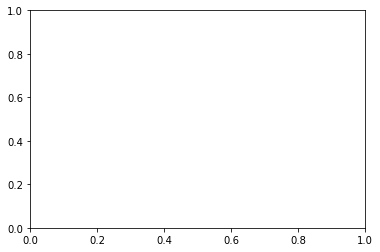

In [ ]:
#%matplotlib
fig, ax = plt.subplots()
labels = ['3 Voltas', '5 voltas', '7 voltas', 'Aberta']
it = [[0, 4], [4, 8], [8, 12], [12, 16]]
for i in range(len(it)):
    par = it[i]

    y = fk.perda_carga(df['TL'][par[0]:par[1]].values)
    x = fk.df_calc_vazão(df[['PO_TL']], min=par[0], max=par[1])

    ax.scatter(x, y, label=f'{labels[i]}')

ax.legend()
ax.grid(ls='dotted')